## The Darcy's equation (piecewise-constant inputs)

## (1) Problem Description
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function. 

We consider a problem with a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

### (2) Prepare data

The shape of a_train: torch.Size([1000, 841])
The shape of x_train: torch.Size([1000, 841, 2])
The shape of gridx_train: torch.Size([841, 2])
**********************************
The shape of a_test: torch.Size([200, 841])
The shape of x_test: torch.Size([200, 841, 2])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])


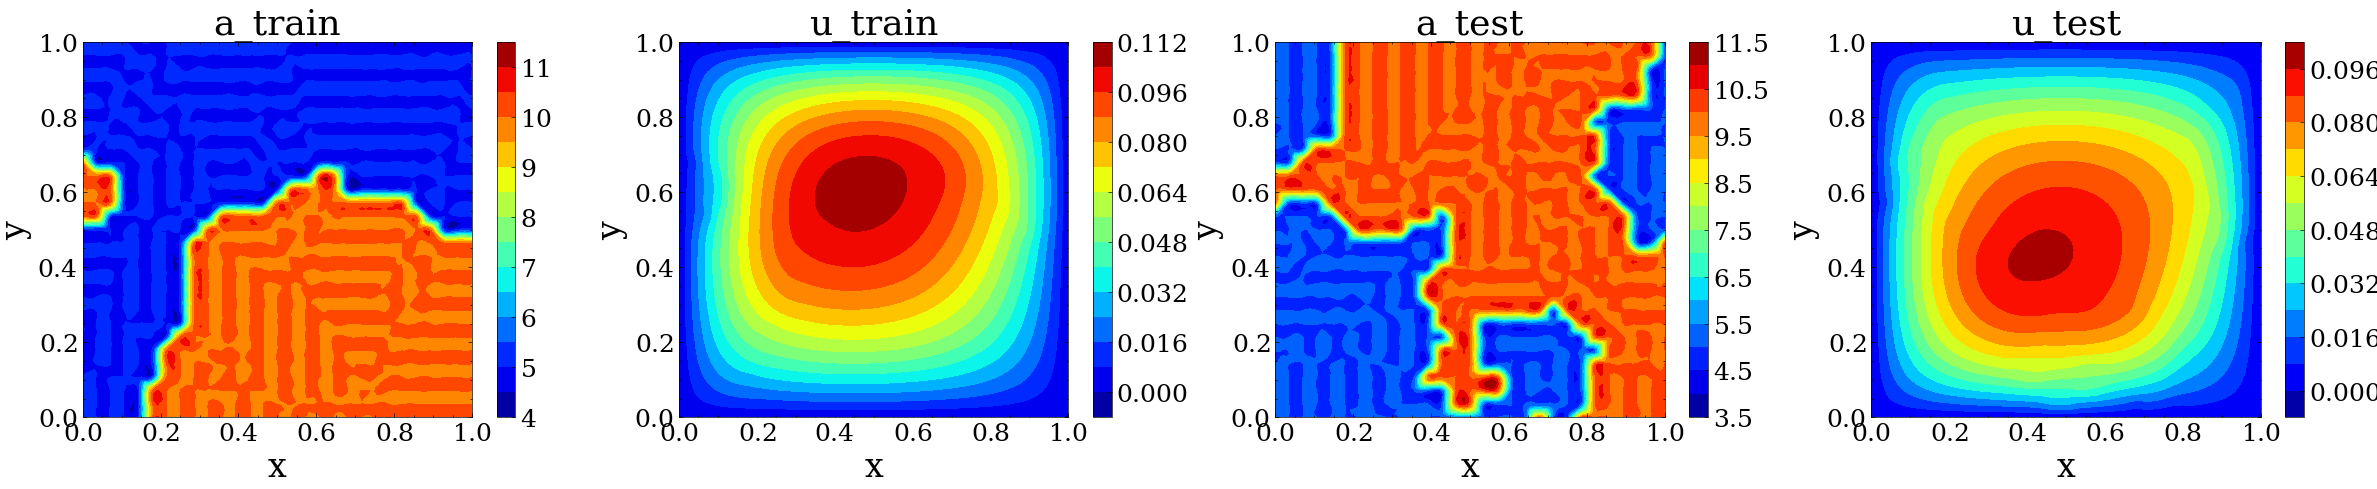

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
res_coe = 29
tag = 'data1000'

######################################
# Load training data
######################################
from Utils.utils import *
#
class Get_High_Resolution_a(object):

    def __init__(self, res=res_coe):
        super(Get_High_Resolution_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x_mesh, a_coe):
        ''' 
        Input:
            x_mesh: size(n_batch, n_mesh, 2)
            a_coe: size(n_batch, nx*ny)
        Result:
            a_new: size(n_batch, n_mesh)
        '''
        x_loc = torch.floor(x_mesh[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x_mesh[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        a_new = a_coe[torch.arange(a_coe.size(0)).unsqueeze(1), loc]
        
        return a_new
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["coe"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    #
    X, Y = np.array(data['X']), np.array(data['Y'])
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    a = a.reshape(ndata, -1)
    a_high_res = Get_High_Resolution_a()(gridx, a)
    x = gridx.repeat((ndata, 1, 1))
    u = u.reshape(ndata, -1, 1)
    
    return a_high_res, u, x, gridx
#
data_train = h5py.File('dataset/pwc_train_data1000.mat', 'r')
data_test = h5py.File('dataset/pwc_test_in.mat', 'r')
a_train, u_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('**********************************')
print('The shape of a_test:', a_test.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)

########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]*4, [a_train[0], u_train[0], a_test[0], u_test[0]], 
                  ['a_train', 'u_train', 'a_test', 'u_test'], lb =0.)

### (3) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)

###############################
# The test function
###############################
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
# Set normalizer
###############################
class UnitGaussianNormalizer():

    def __init__(self, a, eps=1e-8):
        super(UnitGaussianNormalizer, self).__init__()
        '''Apply normaliztion to inputs or outputs
        Input:
            a: size(N, mesh_size)
        Output:
            mean: size(mesh_szie,)
            std: size(mesh_size,)
        '''
        self.mean = torch.mean(a, 0)
        self.std = torch.std(a, 0)
        self.eps = eps
    
    def encode(self, a):
        '''
        Input:
            a: a: size(N, mesh_size)
        '''
        return (a - self.mean) / (self.std + self.eps)
    
    def decode(self, a):
        #
        return a * (self.std + self.eps) + self.mean
#
normalizer_a = UnitGaussianNormalizer(a_train.to(device))

###############################
# The mollifier 
###############################
class mollifier(object):

    def __inint__(self):
        super(mollifier, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        return u.unsqueeze(-1)
        
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        #
        self.mollifier = mollifier()
        self.fun_a = Get_High_Resolution_a(res_coe)
        #
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.model_a = solver.model_dict['a']
        self.model_s1 = solver.model_dict['s1']
        self.model_s2 = solver.model_dict['s2']
        #######################
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)

    def Loss_pde(self, a_batch, nc=100):
        '''The pde loss: weak residuals
        '''
        n_batch = a_batch.shape[0]
        beta = self.model_enc(normalizer_a.encode(a_batch))
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1, 1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = self.fun_a(x.detach(), a_batch).unsqueeze(-1)
        # u: size(n_batch, nc*n_grid) -> size(n_batch, nc*n_grid, 1)
        u = self.model_u(x, beta)
        u = self.mollifier(u, x)
        # s: size(n_batch, nc*n_grid, 2)
        s = torch.stack([self.model_s1(x, beta), self.model_s2(x, beta)], dim=-1)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss #################### 
        res1 = torch.sum( (s - a_detach * du)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
        res1 = torch.mean(res1, dim=-1)
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum(s * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f*v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        res2 = (left-right)**2

        return torch.mean(res1) + torch.mean(res2) * np.sqrt(nc) 
        
    def Loss_data(self, x, a, u):
        '''Note: u is not used for training
        '''
        beta = self.model_enc(normalizer_a.encode(a))
        a_pred = nn.Sigmoid()(self.model_a(x, beta))
        a_true = (a-5.)/5.
        return nn.functional.binary_cross_entropy(a_pred, a_true, reduction='mean')

    def Error(self, x, a, u):
        beta = self.model_enc(normalizer_a.encode(a))
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifier(u_pred, x)

        return self.solver.getError(u_pred, u)
        
######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' 
beta_size = 128      
hidden_size_a = 128
hidden_size = 100

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta

model_enc = Encoder([a_train.shape[1], 512, 256, beta_size], 'SiLU', dtype).to(device)

###################################### The Decoder
trunk_layers, branch_layers = [hidden_size_a]*5, [hidden_size_a]*5
model_a = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)
#
trunk_layers, branch_layers = [hidden_size]*5, [hidden_size]*5
model_u = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)
model_s1 = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)
model_s2 = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u*4:,} total parameters')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])
595,328 training parameters.
94,005 training parameters.
971,348 total parameters


### (4) Train the model

In [3]:
model_dict = {'u':model_u, 's1':model_s1, 's2':model_s2, 'a':model_a, 'enc':model_enc}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.5, step_size=np.int32(5000/10))
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0.125, w_pde=1., batch_size=25, epochs=5000, epoch_show=25,
             **{'save_path':f'saved_models/DGNO_latent{beta_size}_{tag}/'})

  1%|▉                                                                            | 25/2000 [00:59<1:17:51,  2.37s/it]

Epoch:25 Time:59.5177, loss:0.6281, loss_pde:0.5277, loss_data:0.4014
                l2_test:0.1450, lr:0.0005


  2%|█▉                                                                           | 50/2000 [01:58<1:16:58,  2.37s/it]

Epoch:50 Time:118.7131, loss:0.2889, loss_pde:0.2157, loss_data:0.2929
                l2_test:0.0814, lr:0.0005


  4%|██▉                                                                          | 75/2000 [02:58<1:16:54,  2.40s/it]

Epoch:75 Time:178.5546, loss:0.2225, loss_pde:0.1626, loss_data:0.2395
                l2_test:0.0612, lr:0.0005


  5%|███▊                                                                        | 100/2000 [03:58<1:15:45,  2.39s/it]

Epoch:100 Time:238.4250, loss:0.1947, loss_pde:0.1426, loss_data:0.2084
                l2_test:0.0604, lr:0.0005


  6%|████▊                                                                       | 125/2000 [04:58<1:14:49,  2.39s/it]

Epoch:125 Time:298.4388, loss:0.1734, loss_pde:0.1261, loss_data:0.1892
                l2_test:0.0514, lr:0.0005


  8%|█████▋                                                                      | 150/2000 [05:58<1:14:05,  2.40s/it]

Epoch:150 Time:358.5034, loss:0.1586, loss_pde:0.1145, loss_data:0.1762
                l2_test:0.0485, lr:0.0005


  9%|██████▋                                                                     | 175/2000 [06:58<1:13:12,  2.41s/it]

Epoch:175 Time:418.8989, loss:0.1498, loss_pde:0.1087, loss_data:0.1645
                l2_test:0.0473, lr:0.0005


 10%|███████▌                                                                    | 200/2000 [07:58<1:11:47,  2.39s/it]

Epoch:200 Time:478.8506, loss:0.1457, loss_pde:0.1061, loss_data:0.1584
                l2_test:0.0505, lr:0.00025


 11%|████████▌                                                                   | 225/2000 [09:03<1:18:52,  2.67s/it]

Epoch:225 Time:543.3759, loss:0.1335, loss_pde:0.0970, loss_data:0.1459
                l2_test:0.0389, lr:0.00025


 12%|█████████▌                                                                  | 250/2000 [10:08<1:14:04,  2.54s/it]

Epoch:250 Time:608.9308, loss:0.1304, loss_pde:0.0949, loss_data:0.1420
                l2_test:0.0406, lr:0.00025


 14%|██████████▍                                                                 | 275/2000 [11:11<1:09:32,  2.42s/it]

Epoch:275 Time:671.5827, loss:0.1270, loss_pde:0.0925, loss_data:0.1380
                l2_test:0.0386, lr:0.00025


 15%|███████████▍                                                                | 300/2000 [12:11<1:07:55,  2.40s/it]

Epoch:300 Time:731.6263, loss:0.1223, loss_pde:0.0887, loss_data:0.1344
                l2_test:0.0386, lr:0.00025


 16%|████████████▎                                                               | 325/2000 [13:12<1:07:08,  2.41s/it]

Epoch:325 Time:792.0417, loss:0.1208, loss_pde:0.0882, loss_data:0.1306
                l2_test:0.0352, lr:0.00025


 18%|█████████████▎                                                              | 350/2000 [14:12<1:06:05,  2.40s/it]

Epoch:350 Time:852.3627, loss:0.1203, loss_pde:0.0885, loss_data:0.1273
                l2_test:0.0332, lr:0.00025


 19%|██████████████▎                                                             | 375/2000 [15:12<1:05:05,  2.40s/it]

Epoch:375 Time:912.5581, loss:0.1166, loss_pde:0.0855, loss_data:0.1246
                l2_test:0.0313, lr:0.00025


 20%|███████████████▏                                                            | 400/2000 [16:12<1:04:06,  2.40s/it]

Epoch:400 Time:972.8371, loss:0.1141, loss_pde:0.0834, loss_data:0.1226
                l2_test:0.0301, lr:0.000125


 21%|████████████████▏                                                           | 425/2000 [17:13<1:03:27,  2.42s/it]

Epoch:425 Time:1033.1338, loss:0.1107, loss_pde:0.0814, loss_data:0.1174
                l2_test:0.0351, lr:0.000125


 22%|█████████████████                                                           | 450/2000 [18:13<1:02:46,  2.43s/it]

Epoch:450 Time:1093.9036, loss:0.1103, loss_pde:0.0813, loss_data:0.1161
                l2_test:0.0346, lr:0.000125


 24%|██████████████████                                                          | 475/2000 [19:13<1:00:58,  2.40s/it]

Epoch:475 Time:1153.9194, loss:0.1099, loss_pde:0.0813, loss_data:0.1145
                l2_test:0.0308, lr:0.000125


 25%|███████████████████▌                                                          | 500/2000 [20:13<59:51,  2.39s/it]

Epoch:500 Time:1213.7369, loss:0.1075, loss_pde:0.0792, loss_data:0.1131
                l2_test:0.0316, lr:0.000125


 26%|████████████████████▍                                                         | 525/2000 [21:13<59:03,  2.40s/it]

Epoch:525 Time:1273.7343, loss:0.1076, loss_pde:0.0796, loss_data:0.1120
                l2_test:0.0288, lr:0.000125


 28%|█████████████████████▍                                                        | 550/2000 [22:13<57:56,  2.40s/it]

Epoch:550 Time:1333.6067, loss:0.1072, loss_pde:0.0795, loss_data:0.1107
                l2_test:0.0300, lr:0.000125


 29%|██████████████████████▍                                                       | 575/2000 [23:13<56:53,  2.40s/it]

Epoch:575 Time:1393.4301, loss:0.1059, loss_pde:0.0786, loss_data:0.1094
                l2_test:0.0317, lr:0.000125


 30%|██████████████████████▊                                                     | 600/2000 [24:20<1:02:40,  2.69s/it]

Epoch:600 Time:1460.0207, loss:0.1057, loss_pde:0.0786, loss_data:0.1083
                l2_test:0.0314, lr:6.25e-05


 31%|███████████████████████▊                                                    | 625/2000 [25:29<1:05:28,  2.86s/it]

Epoch:625 Time:1529.2753, loss:0.1040, loss_pde:0.0774, loss_data:0.1063
                l2_test:0.0323, lr:6.25e-05


 32%|█████████████████████████▎                                                    | 650/2000 [26:30<53:50,  2.39s/it]

Epoch:650 Time:1590.8399, loss:0.1031, loss_pde:0.0768, loss_data:0.1055
                l2_test:0.0306, lr:6.25e-05


 34%|██████████████████████████▎                                                   | 675/2000 [27:30<52:54,  2.40s/it]

Epoch:675 Time:1650.6806, loss:0.1021, loss_pde:0.0759, loss_data:0.1049
                l2_test:0.0281, lr:6.25e-05


 35%|███████████████████████████▎                                                  | 700/2000 [28:34<56:54,  2.63s/it]

Epoch:700 Time:1714.4136, loss:0.1020, loss_pde:0.0760, loss_data:0.1042
                l2_test:0.0294, lr:6.25e-05


 36%|████████████████████████████▎                                                 | 725/2000 [29:39<53:40,  2.53s/it]

Epoch:725 Time:1779.1515, loss:0.1016, loss_pde:0.0757, loss_data:0.1036
                l2_test:0.0317, lr:6.25e-05


 38%|█████████████████████████████▎                                                | 750/2000 [30:42<50:13,  2.41s/it]

Epoch:750 Time:1842.8836, loss:0.1013, loss_pde:0.0756, loss_data:0.1030
                l2_test:0.0288, lr:6.25e-05


 39%|██████████████████████████████▏                                               | 775/2000 [31:48<56:47,  2.78s/it]

Epoch:775 Time:1908.0308, loss:0.1008, loss_pde:0.0752, loss_data:0.1024
                l2_test:0.0277, lr:6.25e-05


 40%|███████████████████████████████▏                                              | 800/2000 [32:55<52:12,  2.61s/it]

Epoch:800 Time:1975.5442, loss:0.0994, loss_pde:0.0739, loss_data:0.1019
                l2_test:0.0301, lr:3.125e-05


 41%|████████████████████████████████▏                                             | 825/2000 [33:58<47:33,  2.43s/it]

Epoch:825 Time:2038.7152, loss:0.0995, loss_pde:0.0743, loss_data:0.1009
                l2_test:0.0276, lr:3.125e-05


 42%|█████████████████████████████████▏                                            | 850/2000 [34:59<46:15,  2.41s/it]

Epoch:850 Time:2099.0655, loss:0.0994, loss_pde:0.0743, loss_data:0.1007
                l2_test:0.0290, lr:3.125e-05


 44%|██████████████████████████████████▏                                           | 875/2000 [35:59<45:15,  2.41s/it]

Epoch:875 Time:2159.0617, loss:0.0995, loss_pde:0.0745, loss_data:0.1003
                l2_test:0.0306, lr:3.125e-05


 45%|███████████████████████████████████                                           | 900/2000 [36:59<44:01,  2.40s/it]

Epoch:900 Time:2219.1583, loss:0.0999, loss_pde:0.0749, loss_data:0.1000
                l2_test:0.0285, lr:3.125e-05


 46%|████████████████████████████████████                                          | 925/2000 [37:59<42:55,  2.40s/it]

Epoch:925 Time:2279.2068, loss:0.0986, loss_pde:0.0737, loss_data:0.0997
                l2_test:0.0299, lr:3.125e-05


 48%|█████████████████████████████████████                                         | 950/2000 [39:01<43:26,  2.48s/it]

Epoch:950 Time:2341.3040, loss:0.0990, loss_pde:0.0742, loss_data:0.0995
                l2_test:0.0286, lr:3.125e-05


 49%|██████████████████████████████████████                                        | 975/2000 [40:03<42:56,  2.51s/it]

Epoch:975 Time:2403.7982, loss:0.0985, loss_pde:0.0737, loss_data:0.0992
                l2_test:0.0281, lr:3.125e-05


 50%|██████████████████████████████████████▌                                      | 1000/2000 [41:05<39:52,  2.39s/it]

Epoch:1000 Time:2465.3491, loss:0.0976, loss_pde:0.0729, loss_data:0.0990
                l2_test:0.0272, lr:1.5625e-05


 51%|███████████████████████████████████████▍                                     | 1025/2000 [42:10<43:38,  2.69s/it]

Epoch:1025 Time:2530.5737, loss:0.0980, loss_pde:0.0734, loss_data:0.0986
                l2_test:0.0298, lr:1.5625e-05


 52%|████████████████████████████████████████▍                                    | 1050/2000 [43:17<43:05,  2.72s/it]

Epoch:1050 Time:2597.4257, loss:0.0975, loss_pde:0.0729, loss_data:0.0984
                l2_test:0.0286, lr:1.5625e-05


 54%|█████████████████████████████████████████▍                                   | 1075/2000 [44:19<36:52,  2.39s/it]

Epoch:1075 Time:2659.0589, loss:0.0983, loss_pde:0.0737, loss_data:0.0983
                l2_test:0.0288, lr:1.5625e-05


 55%|██████████████████████████████████████████▎                                  | 1100/2000 [45:19<35:58,  2.40s/it]

Epoch:1100 Time:2719.1073, loss:0.0975, loss_pde:0.0729, loss_data:0.0981
                l2_test:0.0286, lr:1.5625e-05


 56%|███████████████████████████████████████████▎                                 | 1125/2000 [46:18<34:53,  2.39s/it]

Epoch:1125 Time:2778.9501, loss:0.0977, loss_pde:0.0732, loss_data:0.0980
                l2_test:0.0292, lr:1.5625e-05


 57%|████████████████████████████████████████████▎                                | 1150/2000 [47:18<33:57,  2.40s/it]

Epoch:1150 Time:2838.9487, loss:0.0969, loss_pde:0.0724, loss_data:0.0979
                l2_test:0.0277, lr:1.5625e-05


 59%|█████████████████████████████████████████████▏                               | 1175/2000 [48:18<33:00,  2.40s/it]

Epoch:1175 Time:2898.9590, loss:0.0974, loss_pde:0.0729, loss_data:0.0978
                l2_test:0.0286, lr:1.5625e-05


 60%|██████████████████████████████████████████████▏                              | 1200/2000 [49:18<31:57,  2.40s/it]

Epoch:1200 Time:2958.9295, loss:0.0976, loss_pde:0.0732, loss_data:0.0976
                l2_test:0.0294, lr:7.8125e-06


 61%|███████████████████████████████████████████████▏                             | 1225/2000 [50:18<31:01,  2.40s/it]

Epoch:1225 Time:3018.9766, loss:0.0969, loss_pde:0.0725, loss_data:0.0974
                l2_test:0.0288, lr:7.8125e-06


 62%|████████████████████████████████████████████████▏                            | 1250/2000 [51:19<30:31,  2.44s/it]

Epoch:1250 Time:3079.2912, loss:0.0965, loss_pde:0.0722, loss_data:0.0974
                l2_test:0.0284, lr:7.8125e-06


 64%|█████████████████████████████████████████████████                            | 1275/2000 [52:19<29:06,  2.41s/it]

Epoch:1275 Time:3139.6243, loss:0.0960, loss_pde:0.0717, loss_data:0.0973
                l2_test:0.0293, lr:7.8125e-06


 65%|██████████████████████████████████████████████████                           | 1300/2000 [53:19<27:55,  2.39s/it]

Epoch:1300 Time:3199.5950, loss:0.0966, loss_pde:0.0723, loss_data:0.0972
                l2_test:0.0274, lr:7.8125e-06


 66%|███████████████████████████████████████████████████                          | 1325/2000 [54:19<26:56,  2.39s/it]

Epoch:1325 Time:3259.5745, loss:0.0967, loss_pde:0.0725, loss_data:0.0972
                l2_test:0.0288, lr:7.8125e-06


 68%|███████████████████████████████████████████████████▉                         | 1350/2000 [55:19<25:59,  2.40s/it]

Epoch:1350 Time:3319.6063, loss:0.0962, loss_pde:0.0720, loss_data:0.0971
                l2_test:0.0281, lr:7.8125e-06


 69%|████████████████████████████████████████████████████▉                        | 1375/2000 [56:19<24:57,  2.40s/it]

Epoch:1375 Time:3379.4486, loss:0.0966, loss_pde:0.0724, loss_data:0.0970
                l2_test:0.0283, lr:7.8125e-06


 70%|█████████████████████████████████████████████████████▉                       | 1400/2000 [57:19<23:56,  2.39s/it]

Epoch:1400 Time:3439.2951, loss:0.0966, loss_pde:0.0724, loss_data:0.0970
                l2_test:0.0266, lr:3.90625e-06


 71%|██████████████████████████████████████████████████████▊                      | 1425/2000 [58:19<23:06,  2.41s/it]

Epoch:1425 Time:3499.2669, loss:0.0956, loss_pde:0.0714, loss_data:0.0969
                l2_test:0.0277, lr:3.90625e-06


 72%|███████████████████████████████████████████████████████▊                     | 1450/2000 [59:19<21:55,  2.39s/it]

Epoch:1450 Time:3559.1763, loss:0.0965, loss_pde:0.0723, loss_data:0.0968
                l2_test:0.0277, lr:3.90625e-06


 74%|███████████████████████████████████████████████████████▎                   | 1475/2000 [1:00:18<20:55,  2.39s/it]

Epoch:1475 Time:3618.9944, loss:0.0962, loss_pde:0.0720, loss_data:0.0968
                l2_test:0.0282, lr:3.90625e-06


 75%|████████████████████████████████████████████████████████▎                  | 1500/2000 [1:01:18<19:57,  2.40s/it]

Epoch:1500 Time:3678.8431, loss:0.0961, loss_pde:0.0719, loss_data:0.0968
                l2_test:0.0279, lr:3.90625e-06


 76%|█████████████████████████████████████████████████████████▏                 | 1525/2000 [1:02:19<19:03,  2.41s/it]

Epoch:1525 Time:3739.0151, loss:0.0958, loss_pde:0.0716, loss_data:0.0967
                l2_test:0.0288, lr:3.90625e-06


 78%|██████████████████████████████████████████████████████████▏                | 1550/2000 [1:03:19<17:58,  2.40s/it]

Epoch:1550 Time:3799.2171, loss:0.0965, loss_pde:0.0723, loss_data:0.0967
                l2_test:0.0272, lr:3.90625e-06


 79%|███████████████████████████████████████████████████████████                | 1575/2000 [1:04:19<16:57,  2.39s/it]

Epoch:1575 Time:3859.1089, loss:0.0959, loss_pde:0.0717, loss_data:0.0967
                l2_test:0.0290, lr:3.90625e-06


 80%|████████████████████████████████████████████████████████████               | 1600/2000 [1:05:19<15:57,  2.39s/it]

Epoch:1600 Time:3919.0128, loss:0.0963, loss_pde:0.0721, loss_data:0.0966
                l2_test:0.0277, lr:1.953125e-06


 81%|████████████████████████████████████████████████████████████▉              | 1625/2000 [1:06:19<15:02,  2.41s/it]

Epoch:1625 Time:3979.0529, loss:0.0966, loss_pde:0.0725, loss_data:0.0966
                l2_test:0.0279, lr:1.953125e-06


 82%|█████████████████████████████████████████████████████████████▉             | 1650/2000 [1:07:19<13:59,  2.40s/it]

Epoch:1650 Time:4039.3746, loss:0.0961, loss_pde:0.0720, loss_data:0.0966
                l2_test:0.0277, lr:1.953125e-06


 84%|██████████████████████████████████████████████████████████████▊            | 1675/2000 [1:08:19<12:59,  2.40s/it]

Epoch:1675 Time:4099.3642, loss:0.0951, loss_pde:0.0710, loss_data:0.0965
                l2_test:0.0287, lr:1.953125e-06


 85%|███████████████████████████████████████████████████████████████▊           | 1700/2000 [1:09:19<12:03,  2.41s/it]

Epoch:1700 Time:4159.3714, loss:0.0963, loss_pde:0.0722, loss_data:0.0965
                l2_test:0.0284, lr:1.953125e-06


 86%|████████████████████████████████████████████████████████████████▋          | 1725/2000 [1:10:19<11:10,  2.44s/it]

Epoch:1725 Time:4219.7739, loss:0.0963, loss_pde:0.0721, loss_data:0.0965
                l2_test:0.0282, lr:1.953125e-06


 88%|█████████████████████████████████████████████████████████████████▋         | 1750/2000 [1:11:20<10:00,  2.40s/it]

Epoch:1750 Time:4280.1795, loss:0.0965, loss_pde:0.0723, loss_data:0.0965
                l2_test:0.0283, lr:1.953125e-06


 89%|██████████████████████████████████████████████████████████████████▌        | 1775/2000 [1:12:20<08:58,  2.39s/it]

Epoch:1775 Time:4340.1977, loss:0.0971, loss_pde:0.0730, loss_data:0.0965
                l2_test:0.0279, lr:1.953125e-06


 90%|███████████████████████████████████████████████████████████████████▌       | 1800/2000 [1:13:20<07:58,  2.39s/it]

Epoch:1800 Time:4400.2590, loss:0.0959, loss_pde:0.0718, loss_data:0.0965
                l2_test:0.0276, lr:9.765625e-07


 91%|████████████████████████████████████████████████████████████████████▍      | 1825/2000 [1:14:20<06:59,  2.39s/it]

Epoch:1825 Time:4460.1253, loss:0.0956, loss_pde:0.0714, loss_data:0.0964
                l2_test:0.0277, lr:9.765625e-07


 92%|█████████████████████████████████████████████████████████████████████▍     | 1850/2000 [1:15:20<05:59,  2.39s/it]

Epoch:1850 Time:4520.0694, loss:0.0966, loss_pde:0.0725, loss_data:0.0964
                l2_test:0.0284, lr:9.765625e-07


 94%|██████████████████████████████████████████████████████████████████████▎    | 1875/2000 [1:16:19<04:59,  2.40s/it]

Epoch:1875 Time:4579.9928, loss:0.0963, loss_pde:0.0722, loss_data:0.0964
                l2_test:0.0281, lr:9.765625e-07


 95%|███████████████████████████████████████████████████████████████████████▎   | 1900/2000 [1:17:20<04:01,  2.42s/it]

Epoch:1900 Time:4640.2461, loss:0.0962, loss_pde:0.0721, loss_data:0.0964
                l2_test:0.0284, lr:9.765625e-07


 96%|████████████████████████████████████████████████████████████████████████▏  | 1925/2000 [1:18:20<03:00,  2.41s/it]

Epoch:1925 Time:4700.6060, loss:0.0958, loss_pde:0.0717, loss_data:0.0964
                l2_test:0.0281, lr:9.765625e-07


 98%|█████████████████████████████████████████████████████████████████████████▏ | 1950/2000 [1:19:20<01:59,  2.40s/it]

Epoch:1950 Time:4760.6101, loss:0.0956, loss_pde:0.0715, loss_data:0.0964
                l2_test:0.0280, lr:9.765625e-07


 99%|██████████████████████████████████████████████████████████████████████████ | 1975/2000 [1:20:20<00:59,  2.40s/it]

Epoch:1975 Time:4820.6171, loss:0.0956, loss_pde:0.0715, loss_data:0.0964
                l2_test:0.0275, lr:9.765625e-07


100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [1:21:21<00:00,  2.44s/it]

Epoch:2000 Time:4881.2527, loss:0.0960, loss_pde:0.0719, loss_data:0.0964
                l2_test:0.0283, lr:4.8828125e-07
The total training time is 4881.3034


### (5) make prediction with trained model

The test l2 error (u avg): tensor(0.0270)


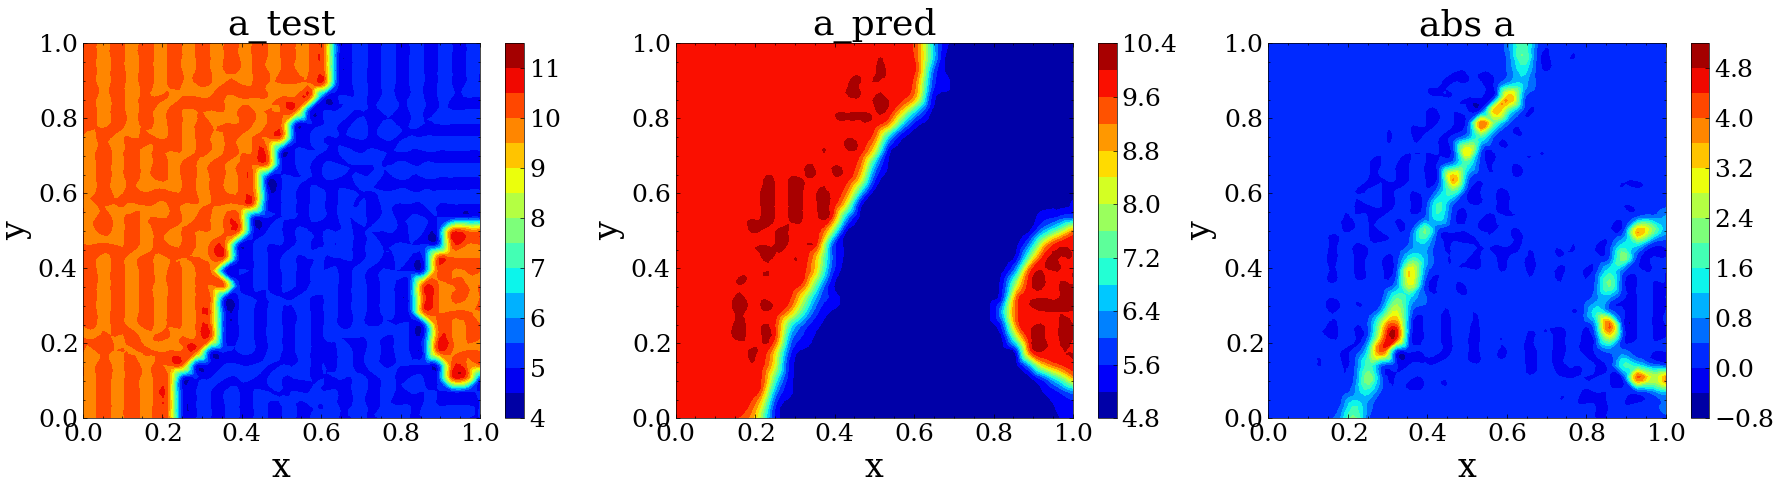

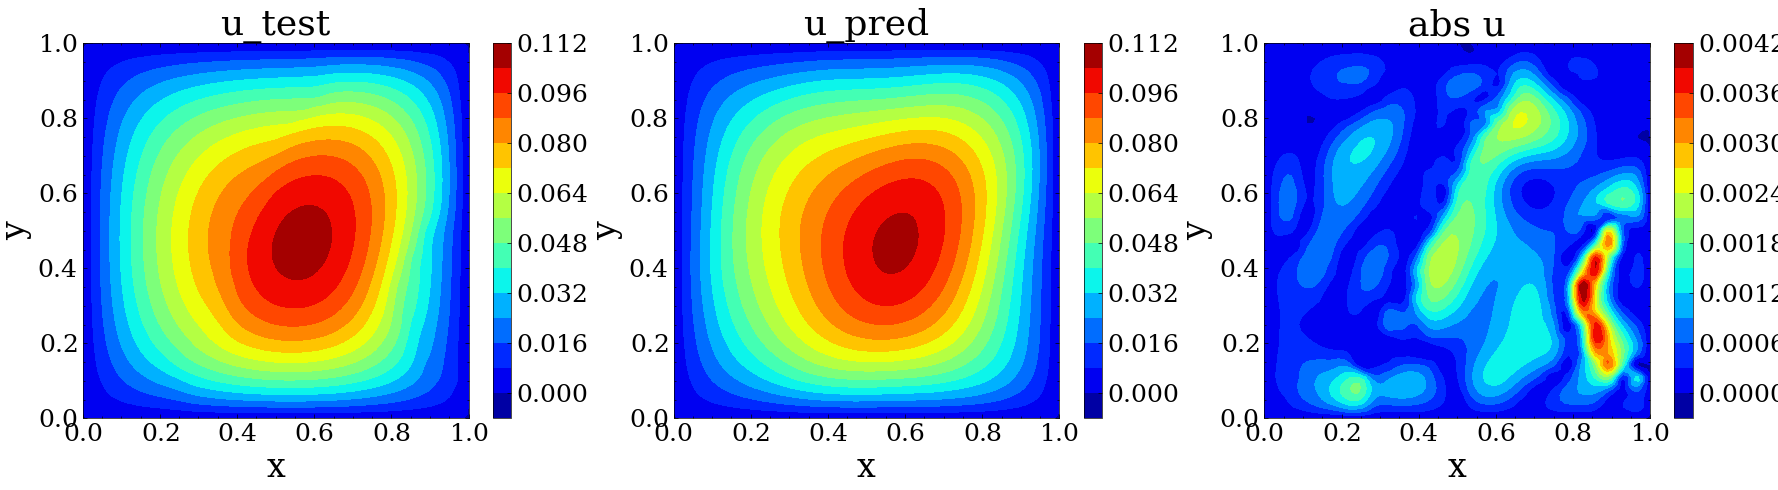

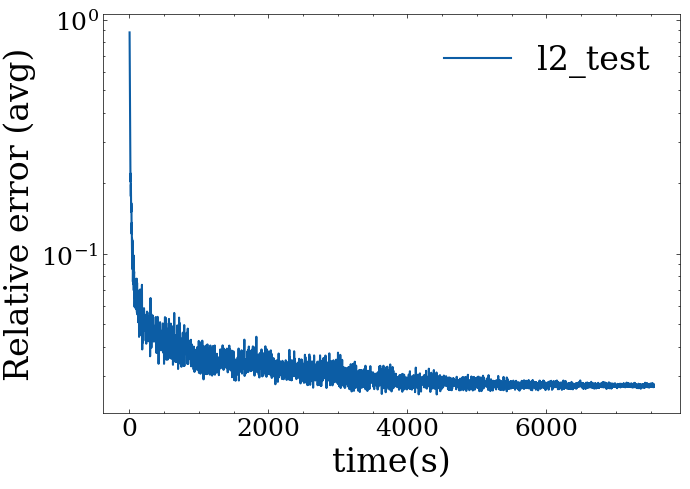

In [5]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent{beta_size}_{tag}/', 
                                 name=f'model_dgno_final')
#
def a_sample(a_prob, samples=50):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a.detach().cpu()

#########################################
data_test = h5py.File('dataset/pwc_test_in.mat', 'r')
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
with torch.no_grad():
    x_a = gridx_train.repeat(a_test.shape[0], 1, 1).to(device)
    x_u = x_test.to(device)
    #
    beta_pred = model_trained['enc'](normalizer_a.encode(a_test.to(device)))
    u_pred = model_trained['u'](x_u, beta_pred)
    u_pred = mollifier()(u_pred, x_u).detach().cpu()
    #
    a_pred = nn.Sigmoid()(model_trained['a'](x_a, beta_pred))
    a_pred = a_sample(a_pred)
#
print('The test l2 error (u avg):', solver.getError(u_pred, u_test))

# # ########################################
from Utils.PlotFigure import Plot
inx = 1
Plot.show_2d_list(gridx_train, [a_test[inx], a_pred[inx], torch.abs(a_test[inx]-a_pred[inx])], 
                  ['a_test', 'a_pred', 'abs a'], lb =0.)
Plot.show_2d_list(gridx_test, [u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  [ 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# # show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_latent{beta_size}_{tag}/', name='loss_dgno')
# Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
#                ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# # show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])